# Introduction

## Dataset

Given a simulated dataset that resembles the data we see after we serve ads in various apps. Each record is an ad that we sent to a user and it contains some information about the device, the app, and the time, and whether the user clicked on the ad or not.

## Objective

The goal is to build a model that can predict if a user will click or not based on the available data points.

## Questions Need to be Answered

- Q1. Inspect and describe the dataset. What changes/data or feature engineering do think should be applied to it?
- Q2. Based on the nature of the data, implement the changes you proposed on the data and apply a simple ML algorithm that you think will make sense for this type of problem and type of dataset. (The actual performance you get isn’t important, Focus on the process and take meaningful steps, and explain your choices)
- Q3. What evaluation metrics will you focus on?
- Q4. What more complex algorithms/techniques would you try if you had more time and data to research this problem? And why?

## Solution Overview

Assumptions:
- Dataset is immutable. We do not have access to modify the raw data.
- Assume that the same app has the same app_key for every user.

Solutions:
- First, we perform exploratory data analysis to inspect the dataset.
- Then, we perform feature engineering.
- Finally, because of the nature of logistic activation function, the output from logistic regression is probability calibrated. We can simply apply a threshold on prediction results to determine if the system should recommend ads to users. I choose logistic regression as the learning algorithm for this task.

# Importing Libraries and Data

## Libraries and Settings

In [1]:
from scipy import sparse
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from utils.constant import COLUMN_NAMES, COLUMN_NAMES_FOR_SELECT, DATASET_SPLIT
from utils.io import load_dataframe_csv, save_dataframe_csv
from utils.preprocess import calculate_mutual_information, fill_nan

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import Data

In [2]:
df_dataset = load_dataframe_csv('data/raw/', 'click_dataset.csv')
df_dataset.columns = COLUMN_NAMES
df_dataset.sort_values('time', inplace=True, ignore_index=True)
df_dataset.head()

b'Skipping line 3731: expected 15 fields, saw 17\n'


,geo_cregion,geo_city,bidder_id,ad_id,device_model,device_os,app_key,day_local,hour_local,app_store_cat,device_language,time,device_devicetype,click,ad_size
0,CA-ON,TORONTO,bidder-24,820401,iPhone,IOS,b_GNcLYpnH2PQZtbdcq7sg..................,5,19,Weather,en,1.604189e+09,1,0,320x50
1,CA-ON,TORONTO,bidder-36,821811,iPhone,IOS,9Pi0TYS9q9QNlA8noa63Uw..................,5,20,Games,en,1.604189e+09,4,0,320x50
2,CA-ON,TORONTO,bidder-41,828301,MotoGPower,ANDROID,5Fva0zXsm3UewfFs-MJ80c6DkJmJatstK9cLQYFhzFs.,5,20,Entertainment,en,1.604189e+09,4,0,300x250
3,CA-ON,TORONTO,bidder-111,821811,iPhone,IOS,pVPfnvr9cmURRSALOCzi5s8rfSVHQh5nXynRm7o8FkvO4h...,5,20,Games,en,1.604189e+09,4,0,320x50
4,CA-ON,TORONTO,bidder-05,828301,iPad,IOS,9Pi0TYS9q9QNlA8noa63Uw..................,5,20,Games,en,1.604189e+09,5,0,728x90


<ins>Observations</ins>:
- All lines have 15 columns except for line 3731 which has 17 columns. Because I have assumed that the dataset is immutable, I will drop line 3731. If I have access to the source of the log, I would dive deep into details to find out why only that line is different. It is possible that the upstream jobs that generate the dataset has some unexpected behaviour.
- All features are discrete except for time.

# Exploratory Data Analysis

## Check Each Feature's Information

In [3]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851298 entries, 0 to 851297
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   geo_cregion        851298 non-null  object 
 1   geo_city           851298 non-null  object 
 2   bidder_id          851298 non-null  object 
 3   ad_id              851298 non-null  int64  
 4   device_model       850877 non-null  object 
 5   device_os          851298 non-null  object 
 6   app_key            851298 non-null  object 
 7   day_local          851298 non-null  int64  
 8   hour_local         851298 non-null  int64  
 9   app_store_cat      734962 non-null  object 
 10  device_language    743151 non-null  object 
 11  time               851298 non-null  float64
 12  device_devicetype  851298 non-null  int64  
 13  click              851298 non-null  int64  
 14  ad_size            851298 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 97

## Handle NaN data

In [4]:
columns_with_nan = df_dataset.columns[df_dataset.isnull().any()].tolist()
columns_with_nan

['device_model', 'app_store_cat', 'device_language']

In [5]:
for column in columns_with_nan:
    fill_nan(df_dataset, column)

<ins>Observations</ins>:
- We find that device_model, app_store_cat and device_language have NaN values. Because they are discrete features, we can either remove these lines or assign a unique category to NaN values. I choose to assign their values to unknown_device_model, unknown_app_store_cat and unknown_device_language accordingly so that we can levarage all given data in the following steps.

## Number of Unique Values for Each Feature

In [6]:
columns_num_unique_values = [(column, len(df_dataset[column].unique())) for column in COLUMN_NAMES]
columns = ['column_name', 'number_unique_values']
df_columns_num_unique_values = pd.DataFrame.from_records(columns_num_unique_values, columns=columns).sort_values('number_unique_values')
df_columns_num_unique_values

,column_name,number_unique_values
1,geo_city,1
5,device_os,2
13,click,2
0,geo_cregion,3
7,day_local,5
12,device_devicetype,8
14,ad_size,11
8,hour_local,24
9,app_store_cat,26
10,device_language,55


In [7]:
print(df_dataset['geo_cregion'].unique())
print(df_dataset['geo_city'].unique())

['CA-ON' 'CA-QC' 'CA-BC']
['TORONTO']


<ins>Observations</ins>:
- We can see that there is only one value for geo_city in the dataset. This means that knowing this feature does not help us to predict if users would like our recommended ads. We can safely drop this feature in the following stages.
- As we already know, geo_cregion represents the country and region codes of where the ad was shown while geo_city represents the city of where the ad was shown. It is obvious that those two features are conflict with each other since city Toronto is not in Quebec nor British Columbia. Therefore, I would investigate further in upstream jobs to find out what causes this and considering to remove both features in later steps. 

## Numerical Features Information

In [8]:
df_dataset.describe()

,ad_id,day_local,hour_local,time,device_devicetype,click
count,851298.000000,851298.000000,851298.000000,8.512980e+05,851298.000000,851298.000000
mean,824123.329085,2.807487,12.332993,1.604316e+09,2.503311,0.050160
std,5138.559191,2.696762,6.582018,7.732355e+04,1.545211,0.218275
min,785002.000000,0.000000,0.000000,1.604189e+09,0.000000,0.000000
25%,817901.000000,0.000000,7.000000,1.604251e+09,1.000000,0.000000
50%,824203.000000,1.000000,13.000000,1.604316e+09,1.000000,0.000000
75%,829412.000000,6.000000,18.000000,1.604382e+09,4.000000,0.000000
max,831702.000000,6.000000,23.000000,1.604448e+09,7.000000,1.000000


<ins>Observations</ins>:
- We can see that there are around 5.016% users click ads. This dataset is unbalanced. A good metric to evaluate learning algorithms is **F1-score**. It might be also worthwile implementing some of the techniques available to tackle imbalanced problems such as downsampling the majority class, upsampling the minority, SMOTE, clustering the majority, etc.

## Visualize Features

###  click

/home/kai/anaconda3/envs/restore_punct/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='click', ylabel='count'>

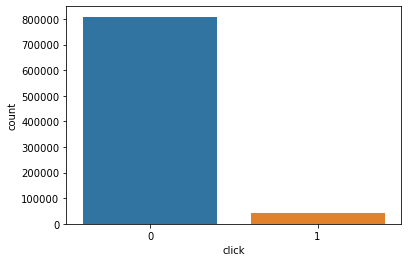

In [9]:
sns.countplot(df_dataset['click'])

<ins>Observations</ins>:
- As we already know, most ads are not clicked. This is why choosing the right metric for evaluation is important. I will choose **F1-score** as the most important metric along with precision and recall. It might be also worthwile implementing some of the techniques available to tackle imbalanced problems such as downsampling the majority class, upsampling the minority, SMOTE, clustering the majority, etc.

### geo_cregion

<AxesSubplot:xlabel='geo_cregion', ylabel='count'>

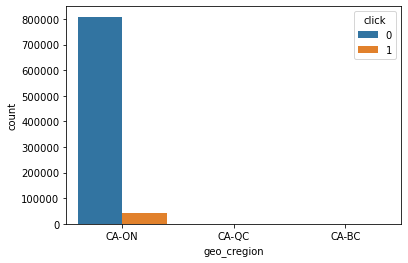

In [10]:
sns.countplot(x='geo_cregion', hue='click', data=df_dataset)

<ins>Observations</ins>:
- Most interactions are in ontario. This feature does not really help us determine if users would click on ads. Additionally, we know that data for this feature has conflict with geo_city. We should consider removing both features in feature selection.

### bidder_id

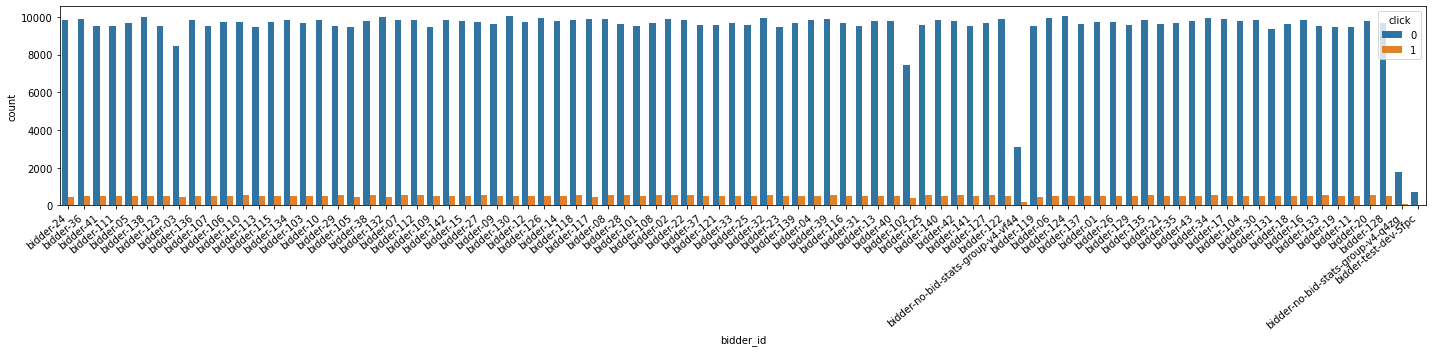

In [11]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='bidder_id', hue='click', data=df_dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

<ins>Observations</ins>:
- Most internal machines send similar number of ads to users except for bidder-03, bidder-102, bidder-no-bid-stats-group-v4-vf44, bidder-no-bid-stats-group-v4-q4zg and bidder-test-dev-5fpc.
- The number of ads that are clicked is similar for most internal machines.
- It is not immediately clear if this feature is useful since there is not enough information in terms of how this works. We do not know if certain ads can only be sent from a bidder or certain bidders only send ads to users live in a specific location.

### ad_id

In [12]:
df_dataset[['ad_id']].value_counts()

ad_id 
830606    90363
830605    59061
824203    39148
820402    28425
817310    27415
          ...  
824308        1
830602        1
830604        1
825001        1
826306        1
Length: 278, dtype: int64

<ins>Observations</ins>:
- ad_id 830606 is the most frequent ad. There are a lot of ads that are only sent out one time. We should consider group ads with low frequencies together.

### device_model

In [13]:
df_dataset[['device_model']].value_counts()

device_model   
iPhone             183515
iPad                32625
SM-G960W            27751
SM-G950W            21522
SM-G973W            19348
                    ...  
GIONEEA1                1
GIONEEF109L             1
GIONEES11lite           1
GLK-AL00                1
zte_blade_v0800         1
Length: 4550, dtype: int64

<ins>Observations</ins>:
- iPhone is the most frequent ad. There are a lot of devices models that are only receive one ad. We should consider group device models with low frequencies together.

### device_os

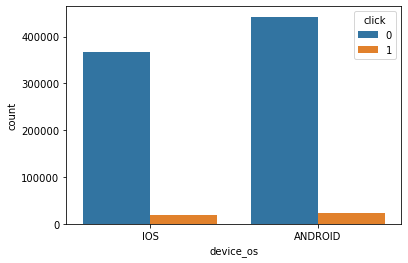

In [14]:
ax = sns.countplot(x='device_os', hue='click', data=df_dataset)

<ins>Observations</ins>:
- Because there are only two discrete values in device_os, we can treat this as a binary feature.

### app_key

In [15]:
df_dataset[['app_key']].value_counts()

app_key                                                                                         
b_GNcLYpnH2PQZtbdcq7sg..................                                                            49196
-8mFWuOSttyWvQDIaF2CqqUi79-5Ug8V4gg877-2W8OLxSMaK0qxaT19tnAHU8LU                                    36936
KYm73gOkLgfjSqNluOoBiTHk4-KyNfeYZ0jLsvPUJAU.                                                        26304
lkCWWqXe_YhIS5QbamseBw..................                                                            23567
y5v4IODpCWwGVpBiVOEeAGkPNkWB0wSd0kCVgZmMkvAQtTbCjdhXUg..                                            17047
                                                                                                    ...  
_0g6suS3xIlT86o_FAQQo_5VUsxNpsJ0TevBSZio59hrvX8ItQcnmgOVPV9uQ3wj7ky1C7vKBoNslSDG7-zl_Q..                1
_0g6suS3xIk7zoJFYk7ZAygRe4fmB3m3zrURRizbwu4h21mIsltOjeYWdbfuG_zaDouJn9UqHzE.                            1
_-qTr4Bi2yvfo80HlPasT__qk6-AYtsr36PNB5T2rE_St_icKZXW6uR

<ins>Observations</ins>:
- b_GNcLYpnH2PQZtbdcq7sg.................. is the most frequent app_key. There are a lot of app_key that are only show one ad. We should consider group app_key with low frequencies together.

### day_local

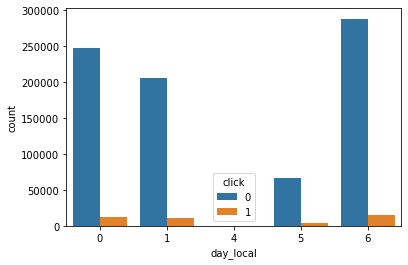

In [16]:
ax = sns.countplot(x='day_local', hue='click', data=df_dataset)

<ins>Observations</ins>:
- We do not have data on day 2 and 3 and few data on day 4.
- The conversion rate does not seem to fluctuate that much on day 0, 1, 5 and 6.
- Users click a lot of ads on day 6, 0 and 1. We should consider grouping days with fewer data.

### hour_local

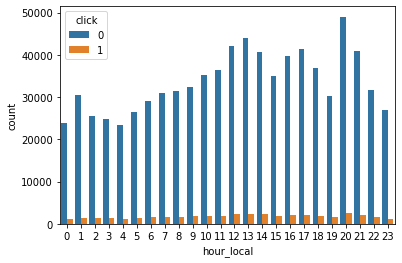

In [17]:
ax = sns.countplot(x='hour_local', hue='click', data=df_dataset)

<ins>Observations</ins>:
- Users tend to click ads during noon and evening.
- The number of ads that are clicked do not fluctuate that much.

### app_store_cat

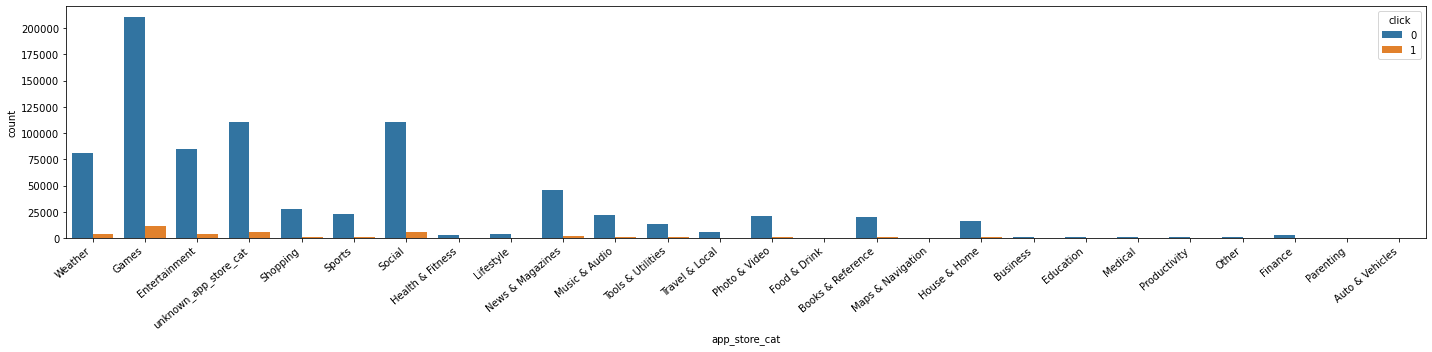

In [18]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='app_store_cat', hue='click', data=df_dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

<ins>Observations</ins>:
- Users tend to click ads on Games and Social.
- There are a lot of app_store_cat have few data. We should consider grouping them into one later.

### device_language

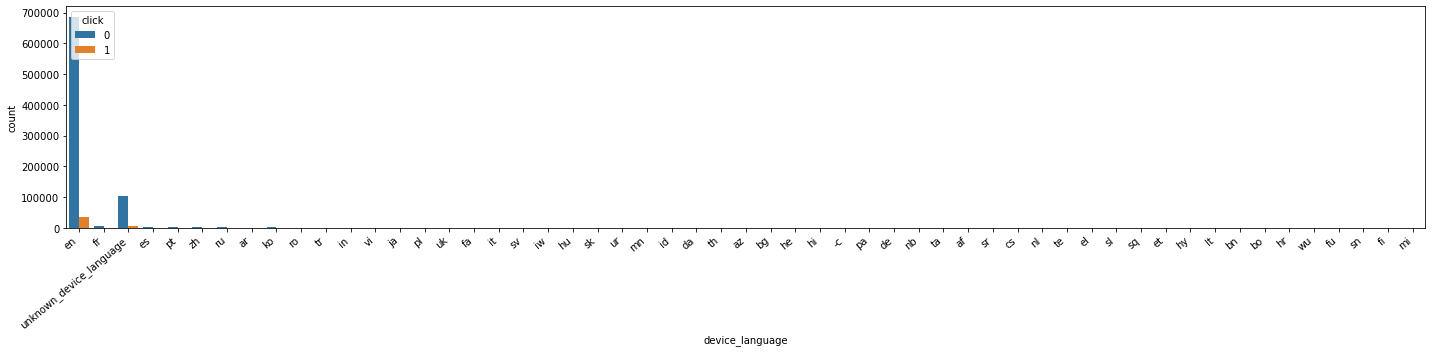

In [19]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='device_language', hue='click', data=df_dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

<ins>Observations</ins>:
- device_language en occurs the most frequent.
- We can treat this as a binary feature. If device_language is en, this feature is 1. Otherwise, this feature is 0.

### device_devicetype

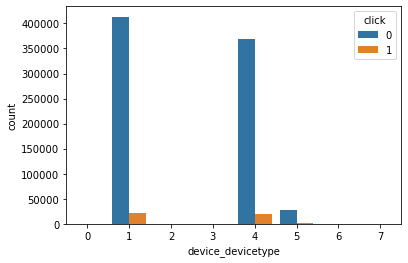

In [20]:
ax = sns.countplot(x='device_devicetype', hue='click', data=df_dataset)

<ins>Observations</ins>:
- Most users use device_devicetype 1 (Mobile/Tablet) and device_devicetype 4 (Phone).
- We can group the rest types into one.

### ad_size

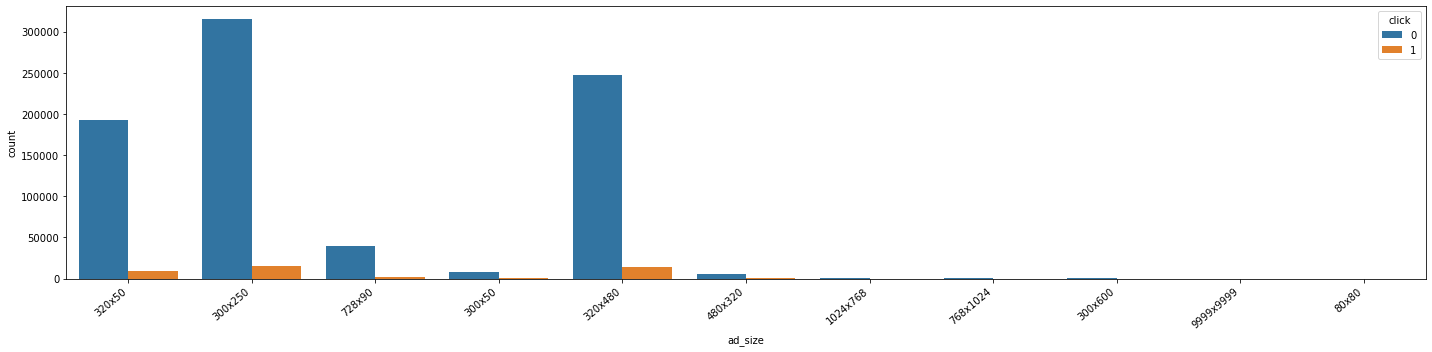

In [21]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='ad_size', hue='click', data=df_dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

<ins>Observations</ins>:
- Most users view ads on size 300x250, 320x480 and 320x50.
- We can group the rest types into one.

## Feature Correlation

In [22]:
corr_features = ['bidder_id', 'ad_id', 'device_model', 'device_os', 'app_key', 'day_local', 'hour_local', 'app_store_cat', 'device_language', 'time', 'device_devicetype', 'click', 'ad_size']
df_heatmap = df_dataset.copy()
for column in corr_features:
    le = LabelEncoder()
    df_heatmap[column] = le.fit_transform(df_heatmap[column])

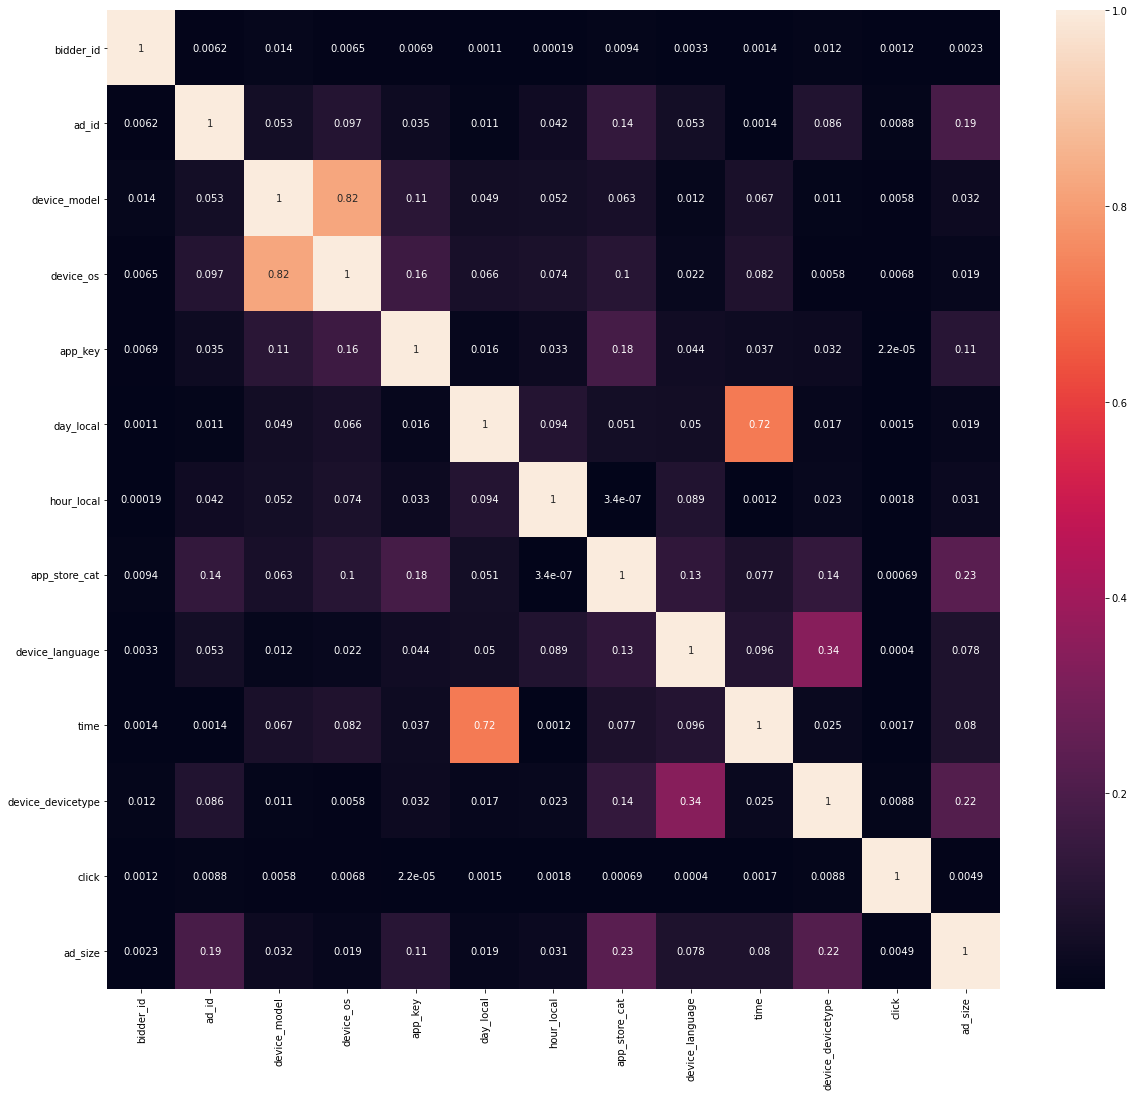

In [23]:
plt.figure(figsize=(20, 18))
sns.heatmap(df_heatmap.corr().abs(), annot=True)
plt.show()

<ins>Observations</ins>:
- device_model and device_os have strong correlation. day_local and time have strong correlation. We can keep these features if we have sufficient memory. Otherwise, we can keep one of two highly correlated features.
- ad_id and device_devicetype have higher correlation to click.

# Data Preprocessing and Feature Engineering

## Remove Unsed Features 

As we have discussed, geo_city only has one distinct value and geo_cregion has conflict with geo_city. time has strong correlation with day_local. device_model and device_os have high correlation. We will remove geo_cregion, geo_city, time and device_model.

In [24]:
df_dataset = df_dataset.drop(['geo_cregion', 'geo_city', 'time', 'device_model'], axis=1)
df_dataset.head()

,bidder_id,ad_id,device_os,app_key,day_local,hour_local,app_store_cat,device_language,device_devicetype,click,ad_size
0,bidder-24,820401,IOS,b_GNcLYpnH2PQZtbdcq7sg..................,5,19,Weather,en,1,0,320x50
1,bidder-36,821811,IOS,9Pi0TYS9q9QNlA8noa63Uw..................,5,20,Games,en,4,0,320x50
2,bidder-41,828301,ANDROID,5Fva0zXsm3UewfFs-MJ80c6DkJmJatstK9cLQYFhzFs.,5,20,Entertainment,en,4,0,300x250
3,bidder-111,821811,IOS,pVPfnvr9cmURRSALOCzi5s8rfSVHQh5nXynRm7o8FkvO4h...,5,20,Games,en,4,0,320x50
4,bidder-05,828301,IOS,9Pi0TYS9q9QNlA8noa63Uw..................,5,20,Games,en,5,0,728x90


## Preprocess Features

### ad_id

In [25]:
ad_id_count = df_dataset[['ad_id']].value_counts()
ad_id_category = {}
ad_id_category[0] = [x[0] for x in ad_id_count.loc[ad_id_count > 1000].index.values] # can also use 2000 as threshold
ad_id_category[1] = [x[0] for x in ad_id_count.loc[ad_id_count <= 1000].index.values]

ad_id_type_dict = {}
for key, values in ad_id_category.items():
    for item in values:
        ad_id_type_dict[item] = key

json.dump(ad_id_type_dict, open("data/processed/ad_id_type_dict.json", "w"))
df_dataset['ad_id'] = df_dataset['ad_id'].apply(lambda x: str(x) if ad_id_type_dict.get(x) == 0 else "other_ad_id")

### device_os

In [26]:
df_dataset.loc[df_dataset['device_os'] == 'IOS', 'device_os'] = 0
df_dataset.loc[df_dataset['device_os'] == 'ANDROID', 'device_os'] = 1
df_dataset.device_os = df_dataset.device_os.astype(int)

### app_key

In [27]:
app_key_count = df_dataset[['app_key']].value_counts()
app_key_category = {}
app_key_category[0] = [x[0] for x in app_key_count.loc[app_key_count > 20].index.values]
app_key_category[1] = [x[0] for x in app_key_count.loc[app_key_count <= 20].index.values]

app_key_type_dict = {}
for key, values in app_key_category.items():
    for item in values:
        app_key_type_dict[item] = key

json.dump(app_key_type_dict, open("data/processed/app_key_type_dict.json", "w"))
df_dataset['app_key'] = df_dataset['app_key'].apply(lambda x: x if app_key_type_dict.get(x) == 0 else "other_app_key")

### day_local

In [28]:
day_local_count = df_dataset[['day_local']].value_counts()
day_local_category = {}
day_local_category[0] = [x[0] for x in day_local_count.loc[day_local_count > 80000].index.values]
day_local_category[1] = [x[0] for x in day_local_count.loc[day_local_count <= 80000].index.values]

day_local_type_dict = {}
for key, values in day_local_category.items():
    for item in values:
        day_local_type_dict[item] = key

json.dump(day_local_type_dict, open("data/processed/day_local_type_dict.json", "w"))
df_dataset['day_local'] = df_dataset['day_local'].apply(lambda x: str(x) if day_local_type_dict.get(x) == 0 else "other_day_local")

### app_store_cat

In [29]:
app_store_cat_count = df_dataset[['app_store_cat']].value_counts()
app_store_cat_category = {}
app_store_cat_category[0] = [x[0] for x in app_store_cat_count.loc[app_store_cat_count > 3000].index.values]
app_store_cat_category[1] = [x[0] for x in app_store_cat_count.loc[app_store_cat_count <= 3000].index.values]

app_store_cat_type_dict = {}
for key, values in app_store_cat_category.items():
    for item in values:
        app_store_cat_type_dict[item] = key

json.dump(app_store_cat_type_dict, open("data/processed/app_store_cat_type_dict.json", "w"))
df_dataset['app_store_cat'] = df_dataset['app_store_cat'].apply(lambda x: x if app_store_cat_type_dict.get(x) == 0 else "other_app_store_cat")

### device_language

In [30]:
device_language_count = df_dataset[['device_language']].value_counts()
device_language_category = {}
device_language_category[0] = [x[0] for x in device_language_count.loc[device_language_count > 200000].index.values]
device_language_category[1] = [x[0] for x in device_language_count.loc[device_language_count <= 200000].index.values]

device_language_type_dict = {}
for key, values in device_language_category.items():
    for item in values:
        device_language_type_dict[item] = key

json.dump(device_language_type_dict, open("data/processed/device_language_type_dict.json", "w"))
df_dataset['device_language'] = df_dataset['device_language'].apply(lambda x: x if device_language_type_dict.get(x) == 0 else "other_device_language")
df_dataset.loc[df_dataset['device_language'] == 'en', 'device_language'] = 1
df_dataset.loc[df_dataset['device_language'] == 'other_device_language', 'device_language'] = 0
df_dataset.device_language = df_dataset.device_language.astype(int)

### device_devicetype

In [31]:
device_devicetype_count = df_dataset[['device_devicetype']].value_counts()
device_devicetype_category = {}
device_devicetype_category[0] = [x[0] for x in device_devicetype_count.loc[device_devicetype_count > 100000].index.values]
device_devicetype_category[1] = [x[0] for x in device_devicetype_count.loc[device_devicetype_count <= 100000].index.values]

device_devicetype_type_dict = {}
for key, values in device_devicetype_category.items():
    for item in values:
        device_devicetype_type_dict[item] = key

json.dump(device_devicetype_type_dict, open("data/processed/device_devicetype_type_dict.json", "w"))
df_dataset['device_devicetype'] = df_dataset['device_devicetype'].apply(lambda x: str(x) if device_devicetype_type_dict.get(x) == 0 else "other_device_devicetype")

### ad_size

In [32]:
ad_size_count = df_dataset[['ad_size']].value_counts()
ad_size_category = {}
ad_size_category[0] = [x[0] for x in ad_size_count.loc[ad_size_count > 50000].index.values]
ad_size_category[1] = [x[0] for x in ad_size_count.loc[ad_size_count <= 50000].index.values]

ad_size_type_dict = {}
for key, values in ad_size_category.items():
    for item in values:
        ad_size_type_dict[item] = key

json.dump(ad_size_type_dict, open("data/processed/ad_size_type_dict.json", "w"))
df_dataset['ad_size'] = df_dataset['ad_size'].apply(lambda x: x if ad_size_type_dict.get(x) == 0 else "other_ad_size")

## Prepare Dataset

In [33]:
columns_num_unique_values = [(column, len(df_dataset[column].unique())) for column in df_dataset.columns]
columns = ['column_name', 'number_unique_values']
df_columns_num_unique_values = pd.DataFrame.from_records(columns_num_unique_values, columns=columns).sort_values('number_unique_values')
df_columns_num_unique_values

,column_name,number_unique_values
2,device_os,2
7,device_language,2
9,click,2
8,device_devicetype,3
4,day_local,4
10,ad_size,4
6,app_store_cat,17
5,hour_local,24
0,bidder_id,86
1,ad_id,102


In [34]:
one_hot_features = ['device_devicetype', 'day_local', 'ad_size', 'app_store_cat', 'hour_local', 'bidder_id', 'ad_id', 'app_key']
for feature in one_hot_features:
    one_hot = pd.get_dummies(df_dataset[feature], prefix=feature)
    # Drop the feature as it is now encoded
    df_dataset = df_dataset.drop(feature, axis = 1)
    # Join the encoded df
    df_dataset = df_dataset.join(one_hot)

In [35]:
features = list(df_dataset.columns)
features.remove('click')

df_train = df_dataset.head(int(len(df_dataset) * DATASET_SPLIT[0]))
x_train = sparse.csr_matrix(df_train[features].to_numpy())
y_train = df_train['click'].to_numpy()

df_valid = df_dataset.iloc[int(len(df_dataset) * DATASET_SPLIT[0]):int(len(df_dataset) * DATASET_SPLIT[0]) + int(len(df_dataset) * DATASET_SPLIT[1])]
x_valid = sparse.csr_matrix(df_valid[features].to_numpy())
y_valid = df_valid['click'].to_numpy()

df_test = df_dataset.iloc[int(len(df_dataset) * DATASET_SPLIT[0]) + int(len(df_dataset) * DATASET_SPLIT[1]):]
x_test = sparse.csr_matrix(df_test[features].to_numpy())
y_test = df_test['click'].to_numpy()

# Model Building

## Hyperparameter Tuning

For hyperparameters tuning, I could use NNI ([Neural Network Intelligence](https://github.com/microsoft/nni)) to tune hyperparameters in an efficient and automatic way. For simplicity, I used grid search to find the l2 regularizer strength which gives the best F1-score on validation set.

In [36]:
# cv_result = {}

# for l2_reg in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000]:
#     clf = LogisticRegression(random_state=0, solver='liblinear', C=l2_reg).fit(x_train, y_train)
#     y_predict = clf.predict(x_valid)
    
#     cv_result[l2_reg] = {}
#     cv_result[l2_reg]['precision_binary'] = precision_score(y_valid, y_predict, average='binary', zero_division=1)
#     cv_result[l2_reg]['precision_mirco'] = precision_score(y_valid, y_predict, average='micro', zero_division=1)
#     cv_result[l2_reg]['precision_macro'] = precision_score(y_valid, y_predict, average='macro', zero_division=1)
#     cv_result[l2_reg]['precision_weighted'] = precision_score(y_valid, y_predict, average='weighted', zero_division=1)
#     cv_result[l2_reg]['precision_non_avg'] = precision_score(y_valid, y_predict, average=None, zero_division=1)
#     cv_result[l2_reg]['recall_binary'] = recall_score(y_valid, y_predict, average='binary')
#     cv_result[l2_reg]['recall_mirco'] = recall_score(y_valid, y_predict, average='micro')
#     cv_result[l2_reg]['recall_macro'] = recall_score(y_valid, y_predict, average='macro')
#     cv_result[l2_reg]['recall_weighted'] = recall_score(y_valid, y_predict, average='weighted')
#     cv_result[l2_reg]['recall_non_avg'] = recall_score(y_valid, y_predict, average=None)
#     cv_result[l2_reg]['f1_binary'] = f1_score(y_valid, y_predict, average='binary')
#     cv_result[l2_reg]['f1_mirco'] = f1_score(y_valid, y_predict, average='micro')
#     cv_result[l2_reg]['f1_macro'] = f1_score(y_valid, y_predict, average='macro')
#     cv_result[l2_reg]['f1_weighted'] = f1_score(y_valid, y_predict, average='weighted')
#     cv_result[l2_reg]['f1_non_avg'] = f1_score(y_valid, y_predict, average=None)
    
# pd.DataFrame(cv_result)

## Model Training, Prediction and Evaluation

In [37]:
x_train = sparse.vstack([x_train, x_valid])
y_train = np.concatenate([y_train, y_valid])

In [38]:
clf = LogisticRegression(random_state=0, solver='liblinear', C=100).fit(x_train, y_train)
y_predict = clf.predict(x_test)

In [39]:
metrics_result = []

micro = {}
micro['Precision'] = precision_score(y_test, y_predict, average='micro', zero_division=1)
micro['Recall'] = recall_score(y_test, y_predict, average='micro')
micro['F1-score'] = f1_score(y_test, y_predict, average='micro')

macro = {}
macro['Precision'] = precision_score(y_test, y_predict, average='macro', zero_division=1)
macro['Recall'] = recall_score(y_test, y_predict, average='macro')
macro['F1-score'] = f1_score(y_test, y_predict, average='macro')

weighted = {}
weighted['Precision'] = precision_score(y_test, y_predict, average='weighted', zero_division=1)
weighted['Recall'] = recall_score(y_test, y_predict, average='weighted')
weighted['F1-score'] = f1_score(y_test, y_predict, average='weighted')

metrics_result.append(micro)
metrics_result.append(macro)
metrics_result.append(weighted)
df_result = pd.DataFrame(metrics_result)

df_result.insert(0, "Metrics", ['Micro Average', 'Macro Average', 'Weighed Average'])

df_result

,Metrics,Precision,Recall,F1-score
0,Micro Average,0.948859,0.948859,0.948859
1,Macro Average,0.491700,0.499901,0.487261
2,Weighed Average,0.903063,0.948859,0.924520


<ins>Observations</ins>:
- First, we will talk about the differences between micro, macro and weighted average. Micro average uses the global number of TP, FN, FP and calculates scores directly without favouring any class in particular. Macro average calculates scores separated by class but not using weights for the aggregation, which resuls in a bigger penalisation when the learning algorithm does not perform well with the minority classes. Weighted average calculates scores for each class independently but when it adds them together uses a weight that depends on the number of true labels of each class. Therefore, it favours the majority class.
- Because we care about class imbalance, micro average is more important in this case. As we have discovered above, the dataset is extremely unbalanced. F1-score is the most important metrics in this case.
- We can see that the logistic regression achieves around 48.7% in terms of F1-score with marco average.

# Conclusion

- I would dive deeper into finding the correlation between features and click. It might be worthwhile looking at the relationship between combined features and click.
- This dataset is extremely unbalanced. It might be worthwile implementing some of the techniques available to tackle imbalanced problems such as downsampling the majority class, upsampling the minority, SMOTE, clustering the majority, etc.
- Because most features are discrete, converting original features to one hot would drastically increases feature dimensions. It might be worthwhile implementing tree-based models. Another way to deal with very sparse training data is to use Factorization Machines (FM) or Field Aware Factorization Machines (FFM).
- This task is about recommending ads to users. It would make sense to leverage as much information about ads as possible. However, the only direct information of ads that is available is ad_id. If an ad only exists in training set, the learning algorithm would not have any direct information about the ad in testing. It would be worthwhile converting ads to latent embeddings using latest representation learning techniques. Then the learning algorithms use that information along with ad_id.
- After exploring linear models (e.g., logistic regression, linear regression, etc) as baselines, it is worthwhile implementing neural networks since neural networks tend to have larger capacity than linear models.
- To increase performance, we can also use ensemble such as bagging and boosting.